# Media Analyser - By Gabriel Hanich

In [1]:
# Imports
import json
from collections import Counter
from datetime import date, datetime
import datetime as dt
import csv

import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as corpusStopwords
from nltk import pos_tag

from wordcloud import WordCloud, STOPWORDS

import praw

import sys
sys.path.append('../') # Allows importing of local modules

from lib.data import GetData
from lib.media import Outlet, Article

In [2]:
# 'widget' displays as interactable inline element where 'qt' opens graph in new window 
%matplotlib widget

In [3]:
# Constants
dataVersion = 2
stopwords = corpusStopwords.words("english")

In [4]:
def daterange(date1, date2): # Returns list of dates between 2 dates
    for n in range(int((date2 - date1).days)+1):
        yield date1 + dt.timedelta(n)

In [5]:
def getNames(dataStr):
    taggedName = pos_tag(word_tokenize(dataStr))
    totalName = ""
    names = [] # List containing each name present in the by-line
    for word in taggedName:
        if len(word[0]) < 3 or word[1] not in allowedPOS:
            if totalName != "":
                names.append(totalName[:-1])
                totalName = ""
        if word[1] in allowedPOS:
            totalName += word[0] + " "
    names.append(totalName[:-1])
    return names

In [6]:
# Takes a 2D array (list of lists) and converts into one list
def flattenList(myList):
    newList = []
    for val in myList:
        if type(val) == list:
            for smallVal in val:
                newList.append(smallVal)
        else:
            newList.append(val)
    return newList

In [7]:
# Return X, Y and Z Vals for a giveb media Outlet (depending on given constants)
def getXYVals(thisOutlet, statType, startDate, endDate, titleSearchWords, commonWordCount):
    # Returns a list containing the x, y and z (annotation) for a given media outlet
    xVals = []
    yVals = []
    zVals = []
    for myDate in list(daterange(startDate, endDate)): # For every date between the given start and end date
        try:
            articleCount = 0
            avgSentiment = 0
            commonWords = []
            totalWords = []
            for articleIndex, article in enumerate(thisOutlet.dayDict[myDate.strftime("%d/%m/%Y")]):
                # If there are no title search words OR title contains wanted word
                if titleSearchWords == [] or set(flattenList(titleSearchWords)).intersection(word_tokenize(article["headline"].lower())):
                    articleCount += 1
                    avgSentiment += article["intensityScore"]
                    for word in word_tokenize(article["headline"]):
                        if len(word) > 2:
                            if word.lower() not in stopwords:
                                totalWords.append(str(word))
            # Get most common key words for the day
            commonWordsRaw = Counter(totalWords).most_common(commonWordCount)
            commonWords = []
            for word in commonWordsRaw:
                commonWords.append(list(word))
            # Append data depending on chosen chart type        
            if statType == "articleCount":
                yVals.append(articleCount)
            elif statType == "avgSentiment":
                try:
                    yVals.append(avgSentiment / articleCount)
                except ZeroDivisionError:
                    yVals.append(0)
            elif statType  == "commonWords":
                yVals.append(articleCount)
                zVals.append(commonWords)

            xVals.append(myDate)
        except KeyError: # In case outlet has no articles published on that date (Returns empty lists)
            pass
    return xVals, yVals, zVals

In [8]:
# Convert .json data to classes
with open("../media Outlets.csv") as outletsFile: # Get list of outlets
    outletsData = GetData(outletsFile)

outlets = []
for thisOutlet in outletsData:
    outlets.append(Outlet(thisOutlet[0]))

    with open("../data/" + str(dataVersion) + "/json/" + thisOutlet[0] + ".json", encoding="utf-8") as dataFile:
        outlets[-1].setDayDict(json.load(dataFile)) # Write daydict to outlet Object

In [9]:
# User settings

# Dates
doSetDates = True # Whether to use user-specified dates
startingDate = "13/9/2021"
endDate = "23/01/2022"

# Outlets
doSetOutlets = False # Whether to limit search to a set of outlets
setOutlets = [] # Only include a set of outlets
doTotalOutlets = True # Whether to take the outlets as a total

# Title searching
titleSearchWords = [] # Only include articles with headlines containing these words (Leave BLANK to disable)

# Similar Words settings
doSimilarWords = False # Whether to scan reddit for similar words to the title search words
searchPostsCount = 500 # How many posts to scan per word
searchWords = 10 # How many words from reddit are added per keyword
minOccurenceCount = 5 # Minimum amount of times a word has to appear to be registered as 'similar'

# Chart Settings
commonWordCount = 1 # How many common words per day are displayed
chartType = "articleCount" # Type of chart to make'
saveAsCSV = False


# Convert string userDates to datetime objs
startingDate = datetime.strptime(startingDate, "%d/%m/%Y")
endDate = datetime.strptime(endDate, "%d/%m/%Y")

In [10]:
# Combine all outlets into one if doTotalOutlets == True
if doTotalOutlets:
    totalOutlet = Outlet("Total")
    thisDayDict = {}
    for date in daterange(startingDate, endDate):
        strDate = datetime.strftime(date, "%d/%m/%Y")
        thisArticleList = []
        for mediaOutlet in outlets:
            try:
                for articleIndex, article in enumerate(mediaOutlet.dayDict[strDate]):
                    thisArticleList.append(article)
            except KeyError:
                pass
        if len(thisArticleList) != 0:
            thisDayDict[strDate] = thisArticleList
    totalOutlet.setDayDict(thisDayDict)

In [11]:
# Scan reddit for similar keywords to those given by titleSearchWords
if doSimilarWords:
    print("Starting")
    similarSearchWords = []
    reddit = praw.Reddit(client_id='GRD68owJs221Qw', client_secret='K1ug6GHtgHiKxkcHBpiO3ei7yRtDWQ', user_agent='Gabriel')
    all = reddit.subreddit("all") # Create subreddit object
    for sectionIndex, section in enumerate(titleSearchWords):
        sectionKeyWords = []
        # Flatten section into single list containing all the words
        wordsList = []
        if type(section) == list: # If list contains sub-lists (i.e has multiple search words per section)
            for word in section:
                wordsList.append(word)
        else:
            wordsList.append(section)
        foundWords = []
        for searchIndex, searchWord in enumerate(wordsList):
            for post in all.search(searchWord, limit=searchPostsCount): # Search for the top (seachCount) posts about (searchWord)
                title = word_tokenize(post.title)
                for word in title:
                    word = word.lower()
                    if not word in stopwords and len(word) > 2:
                        foundWords.append(word)
            print("DONE " + str(round((sectionIndex + 1) / len(titleSearchWords), 2)) + 
              " " + str(round((searchIndex + 1)/ len(wordsList), 2)))
        for keyWord in Counter(foundWords).most_common(searchWords):
            if keyWord[1] >= minOccurenceCount:
                sectionKeyWords.append(str(keyWord[0]))
        similarSearchWords.append(sectionKeyWords)
                    
    print("FINISHED")

In [12]:
# If doSetOutlets, only include user-listed outlets
if doSetOutlets:
    setOutlets = []
    for mediaOutlet in outlets:
        if mediaOutlet.name in setOutlets:
            setOutlets.append(mediaOutlet)


In [13]:
# Save both an unmodified and modified version of titleSearchWords and outlets
if doTotalOutlets:
    plotOutlets = [totalOutlet]
if doSetOutlets:
    plotOutlets = setOutlets
    print("HI")
else:
    plotOutlets = outlets
if doSimilarWords:
    plotSearchWords = similarSearchWords
    print("Similar words run, searchwords = \n" + str(plotSearchWords))
else:
    plotSearchWords = titleSearchWords
    

In [14]:
print(plotOutlets)

[<lib.media.Outlet object at 0x000001BD6ED894F0>, <lib.media.Outlet object at 0x000001BD6ED89820>, <lib.media.Outlet object at 0x000001BD6ED89130>, <lib.media.Outlet object at 0x000001BD6ED9B280>, <lib.media.Outlet object at 0x000001BD6ED9BCD0>, <lib.media.Outlet object at 0x000001BD6ED9B6A0>, <lib.media.Outlet object at 0x000001BD6ED9B3A0>, <lib.media.Outlet object at 0x000001BD6ED9B790>, <lib.media.Outlet object at 0x000001BD6ED9BFA0>, <lib.media.Outlet object at 0x000001BD6ED9B7F0>]


Running
Done 1 /10
Done 2 /10
Done 3 /10
Done 4 /10
Done 5 /10
Done 6 /10
Done 7 /10
Done 8 /10
Done 9 /10
Done 10 /10


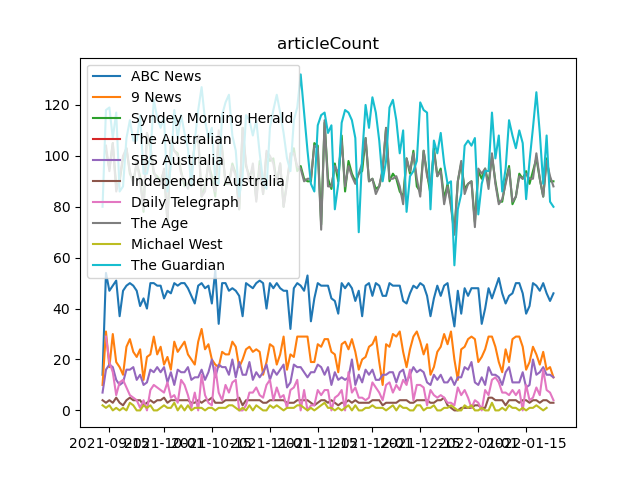

In [15]:
# Plot data 
fig, ax = plt.subplots(1)
ax.set_title(chartType)
print("Running")
for mediaIndex, mediaOutlet in enumerate(plotOutlets):
    try:
        if not doSetDates: # Auto Generate first and last dates if NOT doSetDates
            startingDate = list(mediaOutlet.dayDict.keys())[0] # Get date of first article
            endDate = list(mediaOutlet.dayDict.keys())[-1] # Get date of last article

            startingDate = datetime.strptime(startingDate, "%d/%m/%Y")
            endDate = datetime.strptime(endDate, "%d/%m/%Y")

    except IndexError: # In case outlet has 0 articles at all
        continue
    
    doMultiCategories = False # If multiple catergories off search words is given
    if len(titleSearchWords) != 0:
        if type(titleSearchWords[0]) == list:
            doMultiCategories = True
            for searchList in titleSearchWords:
                xVals, yVals, zVals = getXYVals(mediaOutlet, chartType, startingDate, endDate, searchList, commonWordCount)
                mediaOutlet.setVals(xVals, yVals, zVals)
                ax.plot(xVals, yVals, label=mediaOutlet.name + " [" + str(searchList[0]) + "]")  

                if len(zVals) != 0: # If there are annotations present
                    for dayIndex, dayPoint in enumerate(zVals):
                        for i in range(len(dayPoint)):
                            ax.annotate(dayPoint[i][0], (xVals[dayIndex], yVals[dayIndex] - i))
    if not doMultiCategories:
        xVals, yVals, zVals = getXYVals(mediaOutlet, chartType, startingDate, endDate, plotSearchWords, commonWordCount)
        mediaOutlet.setVals(xVals, yVals, zVals)
        ax.plot(xVals, yVals, label=mediaOutlet.name)  
        
        if len(zVals) != 0: # If there are annotations present
            for dayIndex, dayPoint in enumerate(zVals):
                for i in range(len(dayPoint)):
                    ax.annotate(dayPoint[i][0], (xVals[dayIndex], yVals[dayIndex] - i))
    print("Done " + str(mediaIndex + 1) + " /" + str(len(plotOutlets)))
        
if chartType == "avgSentiment": # Set yLim to max and min possible sentiment scores
    plt.ylim(-1, 1)

ax.legend()

In [16]:
# Text outputs
for mediaOutlet in plotOutlets:
    print(mediaOutlet.name)
    if chartType == "articleCount" or chartType == "commonWords":
        articleCount = 0
        for val in mediaOutlet.yVals:
            articleCount += val
        print("Published " + str(articleCount) + " articles in " + str(len(mediaOutlet.xVals)) + " days")
        try:
            print("An average of ~" + str(round(articleCount / len(mediaOutlet.xVals), 2)) + " articles per day")
        except ZeroDivisionError:
            print("An average of 0 articles per day")
    elif chartType == "avgSentiment":
        largestScore, smallestScore, totalScore = -1, 1, 0
        largestIndex, smallestIndex = 0, 0
        for valIndex, val in enumerate(mediaOutlet.yVals):
            val = round(val, 2)
            totalScore += val
            if val < smallestScore:
                smallestScore = val
                smallestIndex = valIndex
            if val > largestScore:
                largestScore = val
                largestIndex = valIndex
        try:
            print("Had an average daily sentiment of ~" + 
                  str(round(totalScore / len(mediaOutlet.xVals), 2)) + " over " + 
                  str(len(mediaOutlet.xVals)) + " days") 
        except ZeroDivisionError:
            print("Had an average daily sentiment of 0")
            
        try:
            print("Most POSITIVE day was " + 
                  datetime.strftime(mediaOutlet.xVals[largestIndex], "%d/%m/%Y") + 
                  " scoring " + str(largestScore))
            print("Most NEGATIVE day was " + 
                  datetime.strftime(mediaOutlet.xVals[smallestIndex], "%d/%m/%Y") + 
                  " scoring " + str(smallestScore))
        except IndexError:
            print("NO DATA FOR MOST POSITIVE OR NEGATIVE DAYS")
    print("\n")

ABC News
Published 6143 articles in 133 days
An average of ~46.19 articles per day


9 News
Published 3049 articles in 133 days
An average of ~22.92 articles per day


Syndey Morning Herald
Published 12259 articles in 132 days
An average of ~92.87 articles per day


The Australian
Published 0 articles in 0 days
An average of 0 articles per day


SBS Australia
Published 1880 articles in 133 days
An average of ~14.14 articles per day


Independent Australia
Published 450 articles in 133 days
An average of ~3.38 articles per day


Daily Telegraph
Published 925 articles in 132 days
An average of ~7.01 articles per day


The Age
Published 12245 articles in 132 days
An average of ~92.77 articles per day


Michael West
Published 125 articles in 131 days
An average of ~0.95 articles per day


The Guardian
Published 13825 articles in 133 days
An average of ~103.95 articles per day




ABC News WORD PLOT


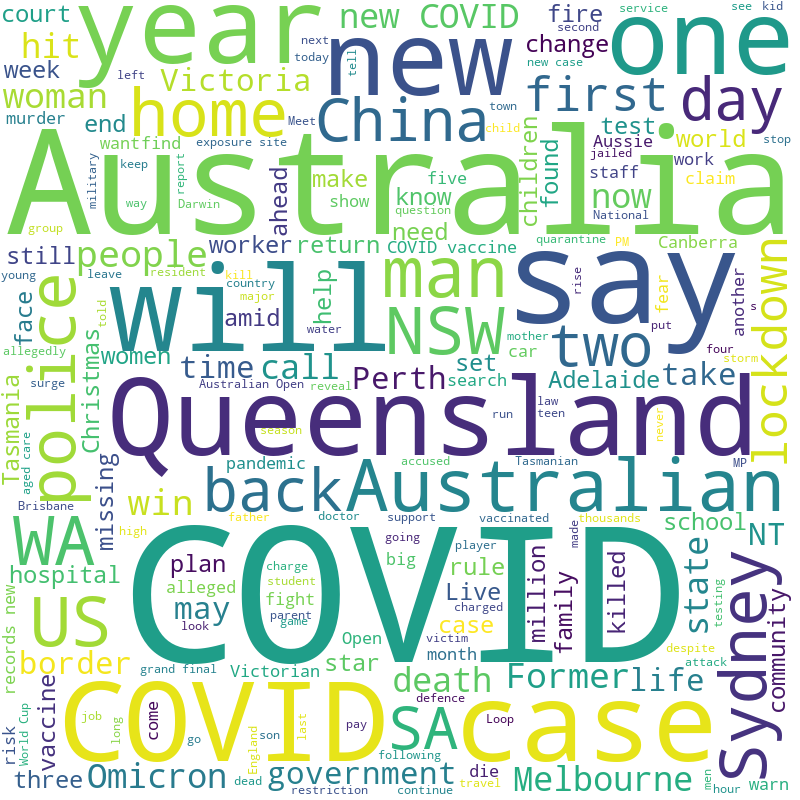

In [17]:
# Create word cloud
stopwords = set(STOPWORDS)

# Change Index below to specify outlet plotted
mediaOutlet = plotOutlets[0]

# Add all words from headlines into single string
articleString = ""
for thisDate in daterange(startingDate, endDate):
    strDate = thisDate.strftime("%d/%m/%Y")
    try:
        for article in mediaOutlet.dayDict[strDate]:
            articleString += article["headline"] + " "
    except KeyError:
        pass
    
wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            stopwords = stopwords,
            min_font_size = 10).generate(articleString)

print(mediaOutlet.name + " WORD PLOT")

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [18]:
if saveAsCSV:# Export X, Y, Z vals as .csv file
    resultsFile = open("../data/" + str(dataVersion) + "/results/" + chartType + ".csv", 
                       "w", encoding='UTF8', newline='')
    csvWriter = csv.writer(resultsFile)
    csvWriter.writerow(["Category: All categories"])
    csvWriter.writerow([])
    nameList = ["day"]
    for mediaOutlet in plotOutlets:
        nameList.append(mediaOutlet.name)

    csvWriter.writerow(nameList)
    for dateIndex, myDate in enumerate(daterange(startingDate, endDate)):
        thisRow = [datetime.strftime(myDate, "%Y-%m-%d")]
        for mediaOutlet in plotOutlets:
            try:
                thisRow.append(mediaOutlet.yVals[dateIndex])
            except IndexError:
                thisRow.append(0)
        csvWriter.writerow(thisRow)
    resultsFile.close()

## Specific Journalist Analysis

In [20]:
doPOSTagging = False

In [21]:
# Get journalist data
authorOutlets = []
authorList = []
for mediaIndex, mediaOutlet in enumerate(outlets):
    for myDate in daterange(startingDate, endDate):
        strDate = datetime.strftime(myDate, "%d/%m/%Y")
        try:
            for thisArticle in mediaOutlet.dayDict[strDate]:                    
                if doPOSTagging: # If user chooses to do POS tagging to find 1st and last names
                    names = getNames(thisArticle["author"])
                else:
                    names = [thisArticle["author"]]
                for name in names:
                    if name not in authorList:
                        authorOutlets.append(Outlet(name))
                        authorList.append(name)
                    for author in authorOutlets:
                        if author.name == name:
                            author.addToDayDict(thisArticle, strDate)
                            break

        except KeyError as e:
            pass
    print(str(mediaIndex + 1) + "/" + str(len(outlets)) + " DONE")

for author in authorOutlets:
    for thisDate in daterange(startingDate, endDate):
        try:
            author.dayDict[thisDate]
        except KeyError:
            author.dayDict[thisDate] = []


1/10 DONE
2/10 DONE
3/10 DONE
4/10 DONE
5/10 DONE
6/10 DONE
7/10 DONE
8/10 DONE
9/10 DONE
10/10 DONE


In [28]:
# Text data readouts per journalist

# Daily Articles
dataDict = {"articleCount": {}, "avgSentiment": {}}
for author in authorOutlets:
    articleCount = 0
    avgSentiment = 0
    for thisDate in daterange(startingDate, endDate):
        strDate = datetime.strftime(thisDate, "%d/%m/%Y")
        try:
            for article in author.dayDict[strDate]:
                articleCount += 1
                avgSentiment += article["intensityScore"]
        except KeyError:
            pass
    dataDict["articleCount"][author.name] = articleCount
    dataDict["avgSentiment"][author.name] = avgSentiment

In [30]:
print(dataDict)

{'articleCount': {'Sara Tomevska': 15, 'Matthew Doran': 39, 'David Campbell': 1, 'Zilla Gordon': 2, 'Sue Lannin': 6, 'David Chau': 11, 'Julia André and Larissa Waterson': 2, 'Kate Ashton': 11, 'Rhiannon Shine': 25, 'Antoinette Radford': 26, 'Charlotte Gore': 12, 'Peter McCutcheon and Bridget Brennan': 3, 'Edwina Seselja': 6, 'Emilie Gramenz': 24, 'Angel Parsons': 5, 'Kate Aubrey': 1, 'Kate McKenna': 10, 'Blake Kagi': 5, 'Gareth Hutchens': 27, "Ted O'Connor": 9, 'Joanna Menagh': 40, 'Sally Sara': 1, 'Mawunyo Gbogbo': 10, 'Eugene Boisvert and Leah MacLennan': 1, 'Alison Xiao': 17, 'Sarah Motherwell': 17, 'Keely Johnson': 5, 'Nour Haydar': 12, 'Richard Willingham': 20, 'Jamie McKinnell': 24, 'James Purtill': 28, 'Claudia Long': 9, 'Dong Xing and Max Walden': 1, 'David Taylor': 30, 'Nakari Thorpe': 8, 'Brittney Kleyn': 8, 'Sarah Jane Bell': 2, 'Kathleen Calderwood': 3, 'Dee Jefferson': 9, 'Olivia Willis': 23, 'Andrew Greene': 58, 'Isabel Dayman and Rebecca Opie': 3, 'Tony Ibrahim': 15, 'Je